# Direct multi-step forecaster

This strategy, commonly known as direct multistep forecasting, is computationally more expensive than the recursive since it requires training several models. However, in some scenarios, it achieves better results. This type of model can be obtained with the `ForecasterAutoregDirect` class and can also include one or multiple exogenous variables.


Direct multi-step forecasting is a time series forecasting strategy in which a separate model is trained to predict each step in the forecast horizon. This is in contrast to recursive multi-step forecasting, where a single model is used to make predictions for all future time steps by recursively using its own output as input.

Direct multi-step forecasting can be more computationally expensive than recursive forecasting since it requires training multiple models. However, it can often achieve better accuracy in certain scenarios, particularly when there are complex patterns and dependencies in the data that are difficult to capture with a single model.

This approach can be performed using the `ForecasterAutoregDirect` class, which can also incorporate one or multiple exogenous variables to improve the accuracy of the forecasts.

<p style="text-align: center">
<img src="../img/diagram-direct-multi-step-forecasting.png" style="width: 700px">
<br>
<font size="2.5"> <i>Diagram of direct multi-step forecasting.</i></font>
</p>

To train a `ForecasterAutoregDirect` a different training matrix is created for each model.

<p style="text-align: center">
<img src="../img/diagram_skforecast_multioutput.png" style="width: 700px">
<br>
<font size="2.5"> <i>Transformation of a time series into matrices to train a direct multi-step forecasting model.</i></font>
</p>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


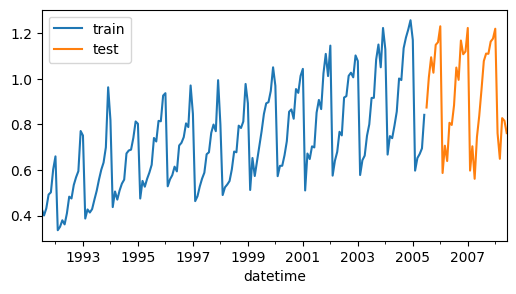

In [2]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Create and train forecaster

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

Starting from version <b>skforecast 0.9.0</b>, the <code>ForecasterAutoregDirect</code> now includes the <code>n_jobs</code> parameter, allowing multi-process parallelization. This allows to train regressors for all steps simultaneously.

The benefits of parallelization depend on several factors, including the regressor used, the number of fits to be performed, and the volume of data involved. When the <code>n_jobs</code> parameter is set to <code>'auto'</code>, the level of parallelization is automatically selected based on heuristic rules that aim to choose the best option for each scenario.

For a more detailed look at parallelization, visit <a href="https://skforecast.org/latest/faq/parallelization-skforecast">Parallelization in skforecast</a>.

</div>

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(),
                 steps         = 36,
                 lags          = 15,
                 transformer_y = None,
                 n_jobs        = 'auto'
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregDirect 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Window size: 15 
Maximum steps predicted: 36 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-05-13 13:23:52 
Last fit date: 2024-05-13 13:23:52 
Skforecast version: 0.12.0 
Python version: 3.11.8 
Forecaster id: None 

## Prediction

When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [4]:
# Predict
# ==============================================================================
# Predict only a subset of steps
predictions = forecaster.predict(steps=[1, 5])
display(predictions)

2005-07-01    0.952051
2005-11-01    1.179922
Name: pred, dtype: float64

In [5]:
# Predict all steps defined in the initialization.
predictions = forecaster.predict()
display(predictions.head(3))

2005-07-01    0.952051
2005-08-01    1.004145
2005-09-01    1.114590
Name: pred, dtype: float64

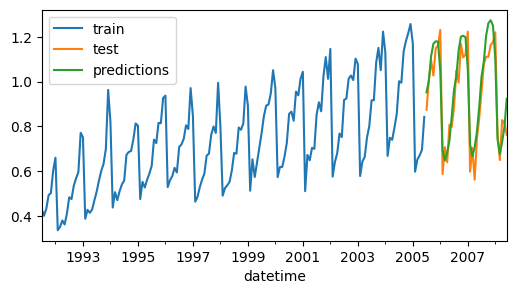

In [6]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [7]:
# Prediction error
# ==============================================================================
predictions = forecaster.predict(steps=36)

error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
            
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.008419597278831965


## Feature importances

Since `ForecasterAutoregDirect` fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [8]:
forecaster.get_feature_importances(step=1)

,feature,importance
11,lag_12,0.551652
10,lag_11,0.154030
0,lag_1,0.139299
12,lag_13,0.057513
1,lag_2,0.051089
2,lag_3,0.044192
9,lag_10,0.020511
8,lag_9,0.011918
7,lag_8,-0.012591
5,lag_6,-0.013233


## Extract training matrices

Two steps are needed to extract the training matrices. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [9]:
# Create the whole train matrix
X, y = forecaster.create_train_X_y(data_train)

# Extract X and y to train the model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step          = 1,
               X_train       = X,
               y_train       = y,
               remove_suffix = False
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-10-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1992-11-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1992-12-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1993-01-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543


In [10]:
y_1.head(4)

datetime
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
Freq: MS, Name: y_step_1, dtype: float64